In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline  


In [3]:
from hogares import EncuestaHogares

encuesta = EncuestaHogares("usu_hogar_T324.xlsx", "usu_individual_T324.xlsx")
hogares, personas = encuesta.memoria()
hogares, personas = encuesta.filtrados_por_region(43, hogares, personas)
subconjunto_hogares, subconjunto_personas = encuesta.subconjunto_columnas(hogares, personas)
subconjunto_hogares_personas = encuesta.df_hogares_personas(subconjunto_hogares, subconjunto_personas)

### Edad
Cuantitativa discreta

In [4]:
personas["edad"].describe()

count    14315.000000
mean        37.251764
std         22.394482
min         -1.000000
25%         18.000000
50%         35.000000
75%         55.000000
max        102.000000
Name: edad, dtype: float64

#### Valores Faltantes/Incorrectos
Hay 101 personas con edad -1.

In [5]:
len(personas[(personas["edad"]==-1)])

101

Se evalúa la fecha de nacimiento

In [34]:
estado = pd.DataFrame([
    (0, "Encuesta no realizada"),
    (1, "Ocupado"),
    (2, "Desocupado"),
    (3, "Inactivo"),
    (4, "Menor de 10 años")
], columns=["estado_actividad", "estado_nombre"])

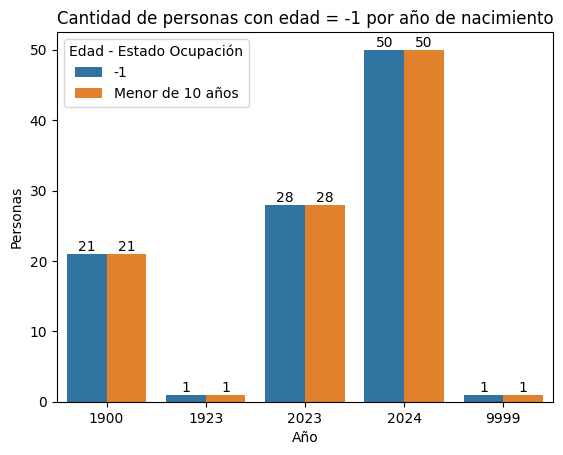

In [44]:
pd.options.mode.copy_on_write = True
ocurrencias_por_anio = pd.merge(personas[personas["edad"]==-1][["edad", "CH05", "estado_actividad"]], estado, on="estado_actividad")
ocurrencias_por_anio.loc[:, "año"] = ocurrencias_por_anio["CH05"].apply(lambda dt: dt.year)
ocurrencias_por_anio = pd.melt(ocurrencias_por_anio, id_vars=['año', "CH05", "estado_actividad"])
ocurrencias_por_anio

g = sns.countplot(data=ocurrencias_por_anio,  x="año", hue="value")
for i in g.containers:
    g.bar_label(i,)
g = g.set(xlabel='Año', ylabel='Personas')
g = plt.legend(title='Edad - Estado Ocupación', loc='upper left')
g = plt.title("Cantidad de personas con edad = -1 por año de nacimiento")
